<a href="https://colab.research.google.com/github/djliden/numerai/blob/main/notebooks/fastai_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Learner with Fastai

The goal of this notebook is to implement a tabular deep learning model using fastai and submit to this week's competition. I eventually plan to build this out into a more structured and modular PyTorch project, but for now I want to make sure that this works and will generate reasonable results.

There's a lot to explore -- such as choice of loss function and evaluation metri [link](https://forum.numer.ai/t/model-evaluation-metrics/337) -- but we're keeping it simple for now.

## Dependencies and Data Download

In [1]:
# install
!pip install --upgrade python-dotenv fastai numerapi

# import dependencies
import os
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import numerapi
from fastai.tabular.all import *

# Secrets setup
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
public_key = os.environ.get("NUMERAI_PUBLIC_KEY")
private_key = os.environ.get("NUMERAI_PRIVATE_KEY")

napi = numerapi.NumerAPI(verbosity="info", public_id=public_key, secret_key=private_key)
napi.download_current_dataset(dest_path="../input/", unzip=True)

     |████████████████████████████████| 194kB 8.2MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


../input/numerai_dataset_252.zip: 392MB [00:06, 61.6MB/s]                           
2021-02-26 03:47:17,370 INFO numerapi.base_api: unzipping file...


'../input/numerai_dataset_252.zip'

## Data Setup

In [2]:
filename = "../input/numerai_dataset_252/numerai_tournament_data.csv"
chunksize = 100000
iter_csv = pd.read_csv(filename, iterator=True, chunksize=chunksize)
val_df = pd.concat([chunk[chunk['data_type'] == 'validation'] for chunk in iter_csv])
val_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [3]:
training_data = pd.read_csv("../input/numerai_dataset_252/numerai_training_data.csv")
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [4]:
training_data = pd.concat([training_data, val_df])
training_data.reset_index(drop=True, inplace=True)

In [5]:
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]
target_cols = ['target']

In [6]:
train_idx, test_idx = training_data.index[training_data.data_type=='train'].tolist(),training_data.index[training_data.data_type=='validation'].tolist()
splits = (list(train_idx), list(test_idx))
#train_idx, test_idx

In [7]:
categorical = ['era']
data = TabularPandas(training_data, cat_names=None,
                    cont_names=list(feature_cols.values),
                    y_names=target_cols, splits = splits)
len(data.train), len(data.valid)

(501808, 137779)

In [8]:
dls = data.dataloaders()

In [9]:
learn = tabular_learner(dls, layers=[200,100],
                        loss_func=MSELossFlat(),
                        metrics = [PearsonCorrCoef()])
#learn.lr_find()

In [10]:
learn.fit_one_cycle(1, wd = 2)

epoch,train_loss,valid_loss,pearsonr,time
0,0.049962,0.049989,0.011866,01:16


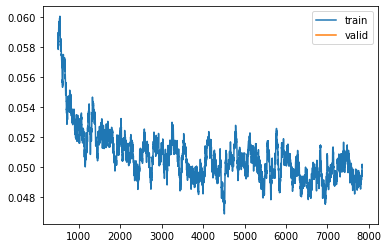

In [11]:
learn.recorder.plot_loss(skip_start = 500)

In [ ]:
from scipy.stats import spearmanr
  
def sharpe(df: pd.DataFrame) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

# Would like to make this a metric that can be tracked with
# fastai but am not sure how.
prediction, target = learn.get_preds()
prediction = prediction.numpy().squeeze()
target = target.numpy().squeeze()
prediction, target

era = dls.valid_ds.items['era']
eval_df = pd.DataFrame({'prediction':prediction, 'target':target, 'era':era}).reset_index()
spearmanr(eval_df.target, eval_df.prediction)

sharpe(eval_df)

0.6429251290222179

In [19]:
class FastSubmission:
  '''Class for generating numerai submissions from fastai learners'''

  def __init__(self, dls, learner, filename, #test_features,
               chunk:bool = True, chunksize:int = 60000,
               debug:bool = False, numerapi=napi,
               outpath = Path("../output/")):
    self.dls = dls
    self.learn = learner
    self.chunk = True
    self.chunksize = chunksize
    #self.test_features = test_features
    self.filename = filename
    self.debug = debug
    self.napi = numerapi
    self.outpath = outpath

  def get_preds_and_ids(self, data_subset):
    data_subset.drop(columns = 'target', inplace = True)
    test_dl = self.dls.test_dl(data_subset) #[self.test_features]
    preds_out,_ = self.learn.get_preds(dl = test_dl, inner = True)
    preds_out = preds_out.tolist()
    preds_out = [item for sublist in preds_out for item in sublist]

    ids_out = data_subset["id"]
    return(preds_out, ids_out)
  
  def get_predictions(self):
    out_list = []
    if self.chunk:
      iter_csv = pd.read_csv(self.filename, iterator=True,
                             chunksize=self.chunksize)
      out_list.extend(self.get_preds_and_ids(x) for x in iter_csv)
    else:
      pred_data = pd.read_csv(self.filename)
      out_list.extend(self.get_preds_and_ids(pred_data))
    
    preds = []
    ids = []
    preds.extend(x[0] for x in out_list)
    preds_out = [item for sublist in preds for item in sublist]
    ids.extend(x[1] for x in out_list)
    ids_out = [item for sublist in ids for item in sublist]

    predictions_df = pd.DataFrame({
    'id':ids_out,
    'prediction_kazutsugi':preds_out
    }) 

    self.predictions = predictions_df
    return(predictions_df)
  
  def save_predictions(self):
    try:
      self.predictions
    except AttributeError:
      print("No predictions to save.\nRemember to run get_predictions first")
    else:
      print("Saving Predictions...\n")
      if ~((self.outpath).exists()):
        self.outpath.mkdir()
      self.predictions.to_csv(self.outpath/ "predictions.csv", index=False)


  def submit(self):
    try:
      self.predictions
    except AttributeError:
      print("No predictions to submit.\nRemember to run get_predictions first!")
    else:
      if ~((self.outpath / "predictions.csv").exists()):
        self.save_predictions()
      print("Submitting Predictions...\n")
      self.napi.upload_predictions(self.outpath / "predictions.csv",
                              model_id=os.environ.get("NUMERAI_MODEL_ID"))

In [20]:
subtest = FastSubmission(dls = dls, learner=learn, chunk=True,
                         chunksize = 100000,
                         filename = "../input/numerai_dataset_252/numerai_tournament_data.csv")

In [21]:
subtest.get_predictions()

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.492945
1,n000920ed083903f,0.487475
2,n0038e640522c4a6,0.512872
3,n004ac94a87dc54b,0.491193
4,n0052fe97ea0c05f,0.492317
...,...,...
1655130,nffd0671ef83cce6,0.490780
1655131,nffd5967c597070e,0.487412
1655132,nffe8a50cc36ece2,0.509958
1655133,nfffa6b427bc1088,0.480655


In [22]:
subtest.submit()

Saving Predictions...



2021-02-26 03:59:29,287 INFO numerapi.base_api: uploading predictions...


Submitting Predictions...



2021-02-26 03:59:30,793 ERROR numerapi.base_api: Can't update submission after deadline if previous submission was on time


ValueError: ignored

In [ ]:
predictions_df = pd.DataFrame({
    'id':ids_out,
    'prediction_kazutsugi':preds_out
})
predictions_df.head()

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.494549
1,n000920ed083903f,0.497768
2,n0038e640522c4a6,0.524293
3,n004ac94a87dc54b,0.499362
4,n0052fe97ea0c05f,0.499735


In [ ]:
data = pd.DataFrame(testsub, columns =['prediction_kazutsugi', 'ids'])
data.head()
#len(testsub[0][1])

,prediction_kazutsugi,ids
0,"[0.4945489764213562, 0.49776843190193176, 0.5242934226989746, 0.49936187267303467, 0.4997352361679077, 0.4995709955692291, 0.49777379631996155, 0.5033504962921143, 0.49993211030960083, 0.4899441599845886, 0.5018358826637268, 0.49855297803878784, 0.5008323788642883, 0.5027129650115967, 0.4998370110988617, 0.49979710578918457, 0.50334632396698, 0.504193127155304, 0.5048102140426636, 0.5029554963111877, 0.5011726021766663, 0.5156298279762268, 0.5067803263664246, 0.5132012367248535, 0.4965677261352539, 0.503463089466095, 0.5028348565101624, 0.4932718873023987, 0.4949806034564972, 0.50537580251...","0 n0003aa52cab36c2 1 n000920ed083903f 2 n0038e640522c4a6 3 n004ac94a87dc54b 4 n0052fe97ea0c05f ... 99995 nfd7c1125fe1a31c 99996 nfd941114ef28020 99997 nfd9b5cb08659ffc 99998 nfd9c554c9c0fdd4 99999 nfda4d9d8cffc2b0 Name: id, Length: 100000, dtype: object"
1,"[0.4960728883743286, 0.4991266131401062, 0.49902284145355225, 0.4933103621006012, 0.5029893517494202, 0.5085550546646118, 0.4925896227359772, 0.5008029937744141, 0.5041283369064331, 0.4945475459098816, 0.5005365610122681, 0.49381133913993835, 0.5049415230751038, 0.500276505947113, 0.49877679347991943, 0.4986007809638977, 0.49572136998176575, 0.5041772127151489, 0.49776020646095276, 0.498372882604599, 0.49824124574661255, 0.49356260895729065, 0.500759482383728, 0.5059297680854797, 0.49938997626304626, 0.5028901696205139, 0.5026234984397888, 0.5000374913215637, 0.5110129714012146, 0.50714832...","100000 nfdab6ac651d2df7 100001 nfdbecf6a9bd49f7 100002 nfddd4686ab95f1f 100003 nfde01d84636029e 100004 nfdea700cd08236c ... 199995 nffabfbb63bca576 199996 nffad64093aca163 199997 nffba5675e36a599 199998 nffbcc2f52d49a1b 199999 nffd76429cae208b Name: id, Length: 100000, dtype: object"
2,"[0.4975372552871704, 0.49526506662368774, 0.5006734132766724, 0.49714723229408264, 0.4964870810508728, 0.5024222731590271, 0.4997471868991852, 0.49813205003738403, 0.5022091865539551, 0.4996761679649353, 0.5059192776679993, 0.49584734439849854, 0.5169950723648071, 0.5046495199203491, 0.4951709806919098, 0.48870256543159485, 0.4995795488357544, 0.485175758600235, 0.49810078740119934, 0.5089253187179565, 0.5000377893447876, 0.5121570229530334, 0.49756067991256714, 0.4919900596141815, 0.5006824731826782, 0.5023658871650696, 0.5062671899795532, 0.4980938136577606, 0.497306227684021, 0.49888026...","200000 nffe49daf3e4c485 200001 nfffc0d41a2a968f 200002 nfffc961408ff165 200003 n000497d910884a6 200004 n001b31869365177 ... 299995 n1d9c2b98da1e219 299996 n1da11d510511a70 299997 n1db601593506b0e 299998 n1db8337dcd86bd8 299999 n1db86685cad9e6a Name: id, Length: 100000, dtype: object"
3,"[0.4936429560184479, 0.48991185426712036, 0.5020437836647034, 0.505989670753479, 0.4989283084869385, 0.5032867193222046, 0.5004370212554932, 0.5052898526191711, 0.4981669485569, 0.49225932359695435, 0.49749755859375, 0.4910353720188141, 0.494347482919693, 0.4916064739227295, 0.5080029368400574, 0.49179601669311523, 0.498442679643631, 0.5054991841316223, 0.5052151679992676, 0.4969039857387543, 0.49965816736221313, 0.5072121620178223, 0.5031494498252869, 0.5009279251098633, 0.5016939640045166, 0.4936475157737732, 0.5022479295730591, 0.4964163601398468, 0.4989817142486572, 0.4998536705970764,...","300000 n1dcef496afa8614 300001 n1de9e7d04d3c476 300002 n1df1534a2f2bea0 300003 n1e02a825765ace3 300004 n1e22e2ed2d0e723 ... 399995 n35bf4850ac6c30e 399996 n35d4d33b6845548 399997 n35d4d7e5b12b38a 399998 n35f3c18e3e7d831 399999 n35f76c73cacd0b4 Name: id, Length: 100000, dtype: object"
4,"[0.5055750012397766, 0.5006178021430969, 0.49943894147872925, 0.49274754524230957, 0.5068169832229614, 0.5146899223327637, 0.49451884627342224, 0.4945177137851715, 0.5018829703330994, 0.4930229187011719, 0.4881919324398041, 0.50998854637146, 0.5032017230987549, 0.5025913119316101, 0.49185243248939514, 0.5042270421981812, 0.5002340078353882, 0.5134915709495544, 0.5017175674438477, 0.5029478073120117, 0.49553239345550537, 0.497276097536087

In [ ]:
ids = []
preds = []

filename = "../input/numerai_dataset_252/numerai_tournament_data.csv"
chunksize = 100000
with pd.read_csv(filename, chunksize=chunksize) as reader:
    for chunk in reader:
        chunk.target = None
        test_dl = dls.test_dl(chunk[feature_cols])
        out,_ = learn.get_preds(dl=test_dl, inner=True)
        #test_df = chunk[feature_cols]
        #preds = learn.pred_batch(test_df)
        out = out.tolist()
        ids.extend(chunk["id"])
        preds.extend(out)

AttributeError: ignored

In [ ]:
len(preds)

1649775

In [ ]:
preds = [item for sublist in preds for item in sublist]

In [ ]:
preds[0:10], ids[0:10], len(preds), len(ids)

([0.49069294333457947,
  0.4867575168609619,
  0.5207219123840332,
  0.5003780126571655,
  0.49850523471832275,
  0.5043054223060608,
  0.49632760882377625,
  0.49158236384391785,
  0.49540552496910095,
  0.48753824830055237],
 ['n0003aa52cab36c2',
  'n000920ed083903f',
  'n0038e640522c4a6',
  'n004ac94a87dc54b',
  'n0052fe97ea0c05f',
  'n00a5ccf3b6b2870',
  'n00bf78d0bbbc1b6',
  'n00c6fd95ff0c83e',
  'n00cd56868258aec',
  'n00e7d6fb71ef69f'],
 1649775,
 1649775)

In [ ]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = pd.DataFrame({
    'id':ids,
    'prediction_kazutsugi':preds
})
predictions_df.head()

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.490693
1,n000920ed083903f,0.486758
2,n0038e640522c4a6,0.520722
3,n004ac94a87dc54b,0.500378
4,n0052fe97ea0c05f,0.498505


In [ ]:
predictions_df.to_csv("../output/predictions.csv", index=False)
# Upload predictions
submission_id = napi.upload_predictions("../output/predictions.csv",
                                        model_id=os.environ.get("NUMERAI_MODEL_ID"))

2021-02-15 15:42:12,812 INFO numerapi.base_api: uploading predictions...
2021-02-15 15:43:02,959 ERROR numerapi.base_api: Can't update submission after deadline if previous submission was on time


ValueError: Can't update submission after deadline if previous submission was on time